## Dimensional Reduction

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('delta.csv', index_col='Aircraft')

In [19]:
print(df.head())

                  Seat Width (Club)  Seat Pitch (Club)  Seat (Club)  \
Aircraft                                                              
Airbus A319                     0.0                  0            0   
Airbus A319 VIP                19.4                 44           12   
Airbus A320                     0.0                  0            0   
Airbus A320 32-R                0.0                  0            0   
Airbus A330-200                 0.0                  0            0   

                  Seat Width (First Class)  Seat Pitch (First Class)  \
Aircraft                                                               
Airbus A319                           21.0                      36.0   
Airbus A319 VIP                       19.4                      40.0   
Airbus A320                           21.0                      36.0   
Airbus A320 32-R                      21.0                      36.0   
Airbus A330-200                        0.0                       0.0  

In [20]:
def plot_pairgrid(df):
    '''
    Uses seaborn.PairGrid to visualize the attributes related to the six physical characteristics.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from importing delta.csv.
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    new=df[['Cruising Speed (mph)', 'Range (miles)', 'Engines','Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']]
    ax=sns.PairGrid(new)
    ax.map_diag(plt.hist)
    ax.map_offdiag(plt.scatter)
    return ax

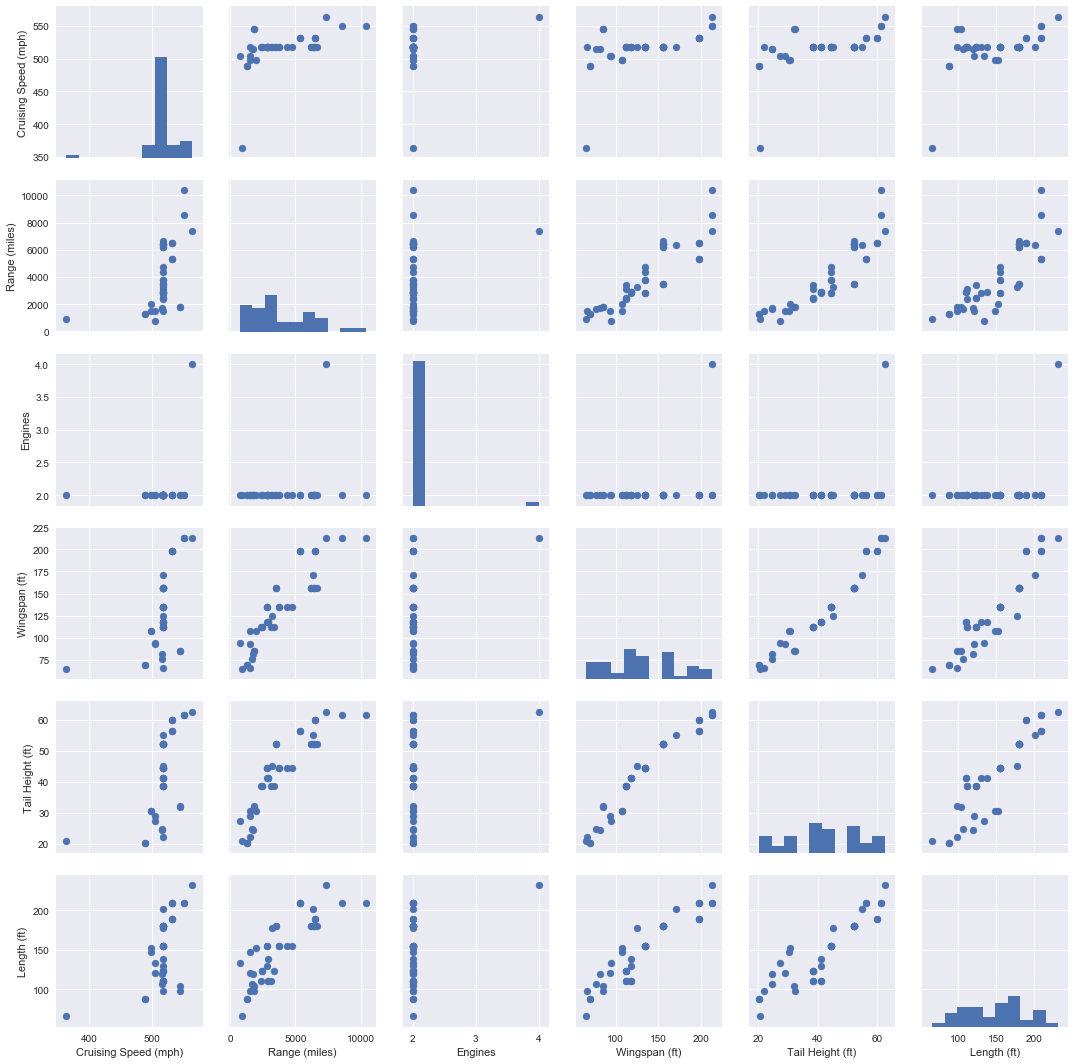

In [16]:
pg=plot_pairgrid(df)

In [17]:
cols = ['Cruising Speed (mph)', 'Range (miles)', 'Engines',
        'Wingspan (ft)', 'Tail Height (ft)', 'Length (ft)']

assert_is_instance(pg.fig, plt.Figure)
assert_equal(set(pg.data.columns), set(cols))

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 10)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = df[cols[j]]
    y_in = df[cols[i]]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

In [19]:
def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    An sklearn.decomposition.pca.PCA instance.
    '''
    pca = PCA(n_components=n_components)
    pca.fit(df)
    return pca

In [20]:
pca_naive = fit_pca(df, n_components=df.shape[1])

In [21]:
assert_is_instance(pca_naive, PCA)
assert_almost_equal(pca_naive.explained_variance_ratio_.sum(), 1.0, 3)
assert_equal(pca_naive.n_components_, df.shape[1])
assert_equal(pca_naive.whiten, False)

In [60]:
def plot_naive_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Attributes are not scaled, hence a naive approach.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    sns.set(style="ticks", font_scale=2.0)
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(pca.explained_variance_ratio_)
    ax.set_xlabel('principal component')
    ax.set_ylabel('Explained Variance')
    ax.set_title('Attributes not scaled')
    sns.despine(offset=5)
    return ax

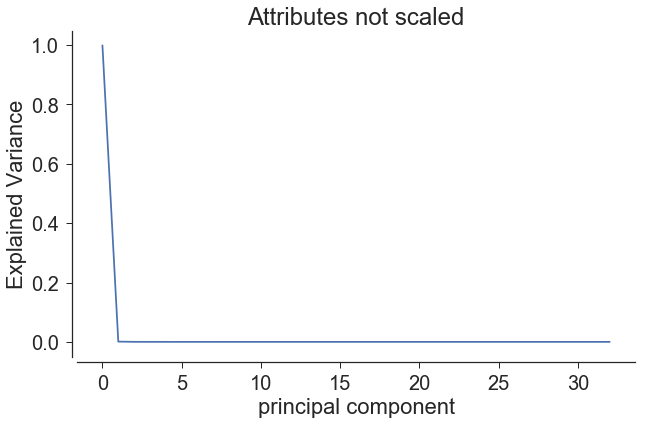

In [61]:
naive_var = plot_naive_variance(pca_naive)

In [62]:
assert_is_instance(naive_var, mpl.axes.Axes)
assert_equal(len(naive_var.lines), 1)

assert_is_not(len(naive_var.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(naive_var.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(naive_var.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

xdata, ydata = naive_var.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(df.shape[1])))
assert_array_almost_equal(ydata, pca_naive.explained_variance_ratio_)

In [63]:
abs_val = np.abs(pca_naive.components_[0])
max_pos = abs_val.argmax()
max_val = abs_val.max()

print('"{0}" accounts for {1:0.3f} % of the variance.'.format(df.columns[max_pos], max_val))


"Range (miles)" accounts for 0.999 % of the variance.


In [68]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    scaler=StandardScaler().fit(df)
    new=scaler.transform(df)  
    return new

In [69]:
scaled = standardize(df)

In [70]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )

In [93]:
n_components = 10
pca = fit_pca(scaled, n_components=n_components)

In [139]:
def plot_scaled_variance(pca):
    '''
    Plots the variance explained by each of the principal components.
    Features are scaled with sklearn.StandardScaler.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.pca.PCA instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    sns.set(style="ticks", font_scale=2.0)
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(pca.explained_variance_ratio_)
    var = np.cumsum(pca.explained_variance_ratio_)
    vls = np.array([np.argmax(var > 0.85)])
    ax.vlines(vls, 0.0, 0.2, linestyles='dashed')
    ax.text(vls[0], 0.21, str('85%'), fontsize = 18, color=sns.xkcd_rgb["pale red"], horizontalalignment='center')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Explained Variance')
    ax.set_title('Features are scaled')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 0.45)
    sns.despine()
    return ax

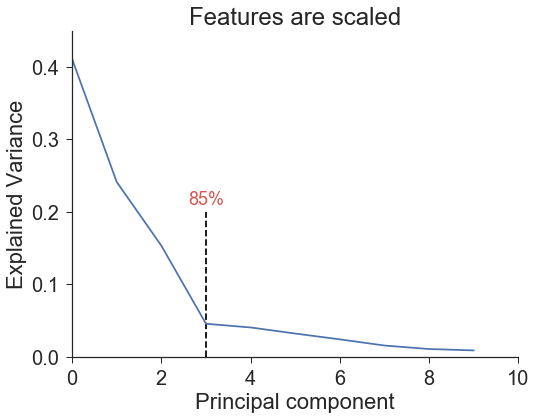

In [140]:
ax=plot_scaled_variance(pca)

In [133]:
assert_is_instance(ax, mpl.axes.Axes)
assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

xdata, ydata = ax.lines[0].get_xydata().T
assert_array_equal(xdata, list(range(n_components)))
assert_array_almost_equal(ydata, pca.explained_variance_ratio_)

In [134]:
def reduce(pca, array):
    '''
    Applies the `pca` model on array.
    
    Parameters
    ----------
    pca: An sklearn.decomposition.PCA instance.
    
    Returns
    -------
    A Numpy array
    '''
    reduced=pca.fit_transform(array)
    return reduced

In [135]:
reduced = reduce(pca, scaled)

In [136]:
assert_is_instance(reduced, np.ndarray)
assert_array_almost_equal(reduced, pca.fit_transform(scaled))

## Clustering

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

In [2]:
reduced = np.load('delta_reduced.npy')

In [3]:
def cluster(array, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    k_means = KMeans(n_clusters=n_clusters,random_state=random_state)
    k_means.fit(array)
    y_pred = k_means.predict(array)
    return k_means, y_pred

In [4]:
k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(1), n_clusters=5)

assert_is_instance(k_means_t, sklearn.cluster.k_means_.KMeans)
assert_is_instance(cluster_t, np.ndarray)
assert_equal(k_means_t.n_init, 10)
assert_equal(k_means_t.n_clusters, 5)
assert_equal(len(cluster_t), len(reduced))
assert_true((cluster_t < 5).all()) # n_cluster = 5 so labels should be between 0 and 5
assert_true((cluster_t >= 0).all())
labels_gold = -1. * np.ones(len(reduced), dtype=np.int)
mindist = np.empty(len(reduced))
mindist.fill(np.infty)
for i in range(5):
    dist = np.sum((reduced - k_means_t.cluster_centers_[i])**2., axis=1)
    labels_gold[dist < mindist] = i
    mindist = np.minimum(dist, mindist)
assert_true((mindist >= 0.0).all())
assert_true((labels_gold != -1).all())
assert_array_equal(labels_gold, cluster_t)

In [7]:
def plot_inertia(array, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    result=[]
    for i in range(start, end+1):
        k_means=cluster(array, random_state=check_random_state(0), n_clusters=i)[0]
        inta=k_means.inertia_ 
        result.append(inta)
    fig, ax = plt.subplots(figsize=(10,6))
    sns.set(style="ticks", font_scale=2.0)
    plt.plot(np.arange(start, end+1, 1),result)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('The elbow method')
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 1600)
    return ax

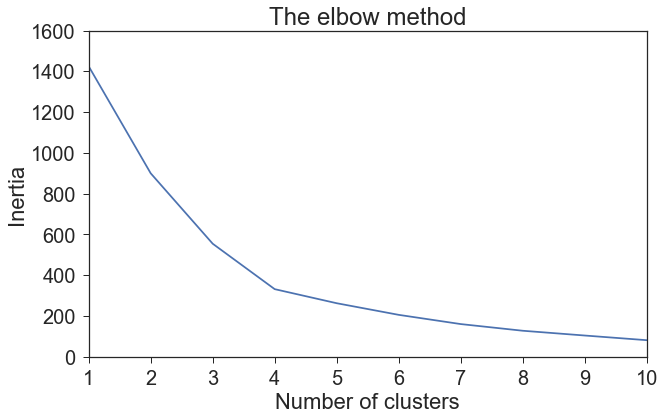

In [8]:
inertia = plot_inertia(reduced)

In [9]:
assert_is_instance(inertia, mpl.axes.Axes)
assert_true(len(inertia.lines) >= 1)

xdata, ydata = inertia.lines[0].get_xydata().T

for i in range(1, 11):
    k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(0), n_clusters=i)
    assert_array_equal(xdata[i - 1], i)
    assert_almost_equal(ydata[i - 1], k_means_t.inertia_)

assert_is_not(len(inertia.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(inertia.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(inertia.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

In [202]:
def plot_pair(reduced, clusters):
    '''
    Uses seaborn.PairGrid to visualize the data distribution
    when axes are the first four principal components.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    reduced: A numpy array. Comes from importing delta_reduced.npy
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    new=pd.DataFrame(reduced).iloc[:,0:4]
    new.columns=['PCA1','PCA2','PCA3','PCA4']
    cls=pd.DataFrame(clusters,columns=['type'])
    ncls=pd.concat([new,cls],axis=1)
    ax=sns.PairGrid(ncls, vars=['PCA1','PCA2','PCA3','PCA4'], hue="type")
    ax.map_diag(plt.hist)
    ax.map_offdiag(plt.scatter)
    return ax

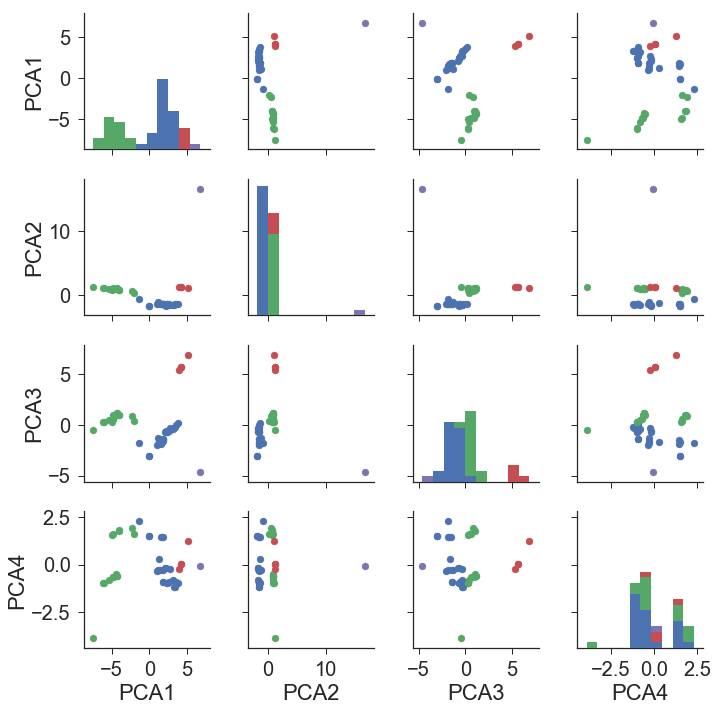

In [203]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

In [204]:
assert_is_instance(pg.fig, plt.Figure)
assert_true(len(pg.data.columns) >= 4)

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 4 * 10) # 4 clusters with 10 patches in each histogram

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_out, y_out = ax.collections[0].get_offsets().T
    x_in = reduced[clusters == 0, j] # we only check the first cluster
    y_in = reduced[clusters == 0, i]
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = reduced[clusters == 0, j]
    y_in = reduced[clusters == 0, i]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

In [205]:
df = pd.read_csv('delta.csv', index_col='Aircraft')
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean()
print(df_grouped.Accommodation)

Clusters
0    153.625000
1    244.733333
2     44.500000
3     54.000000
Name: Accommodation, dtype: float64


In [206]:
print(df_grouped['Length (ft)'])

Clusters
0    137.048083
1    190.538400
2     84.810750
3    111.000000
Name: Length (ft), dtype: float64


In [207]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


In [208]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


In [209]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


In [210]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


In [211]:
print(df.loc[clust1.index, cols_seat])

                          First Class  Business  Eco Comfort  Economy
Aircraft                                                             
Airbus A330-200                     0         1            1        1
Airbus A330-200 (3L2)               0         1            1        1
Airbus A330-200 (3L3)               0         1            1        1
Airbus A330-300                     0         1            1        1
Boeing 747-400 (74S)                0         1            1        1
Boeing 757-200 (75E)                0         1            1        1
Boeing 757-200 (75X)                0         1            1        1
Boeing 767-300 (76G)                0         1            1        1
Boeing 767-300 (76L)                0         1            1        1
Boeing 767-300 (76T)                0         1            1        1
Boeing 767-300 (76Z V.1)            0         1            1        1
Boeing 767-300 (76Z V.2)            0         1            1        1
Boeing 767-400 (76D)

In [212]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

In [213]:
print(df.loc[clust0.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   

## Density Estimation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
from scipy import stats, integrate
from sklearn.neighbors import KernelDensity

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

In [2]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(13, 16))

In [3]:
local = df[df['Origin'] == 'CMI']
local = local.drop(['Origin'], axis=1) 
local.dropna(inplace=True)

In [294]:
def plot_rugplot(df, column='AirTime', jitter=0.0, seed=0):
    '''
    Plots a rug plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    jitter: An int or float. Default: 0.
            If jitter > 0, uses numpy.random.normal() to draw
            random samples from a normal distribution with zero mean
            and standard deviatation equal to "jitter".
    seed: An int. Used by numpy.random.seed().
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    data = []
    if jitter>0:
        np.random.seed(seed=seed)
        new=data.append(df[column] + np.random.normal(0, jitter, len(df[column])))
    elif jitter<=0:
        new=data.append(df[column])
    fig, ax = plt.subplots(figsize=(8, 2))
    clr=sns.xkcd_rgb["pale red"]
    for dat in data:
        sns.rugplot(ax=ax, a=dat, height=0.5, c = clr)
        ax.set_yticks([])
        ax.set_xlim(20, 90)
        ax.set_xlabel('AirTime', fontsize=14)
        sns.despine(left=True, offset=2, trim=True)
    return ax

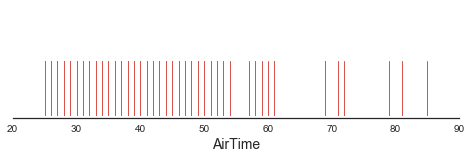

In [295]:
rug_no_jitter = plot_rugplot(df=local, jitter=0, seed=0)

In [296]:
assert_is_instance(rug_no_jitter, mpl.axes.Axes)
assert_equal(len(rug_no_jitter.lines), len(local))

for i in range(len(local)):
    xdata, ydata = rug_no_jitter.lines[i].get_xydata().T
    assert_array_equal(xdata, local.iloc[i, 0])
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_no_jitter.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

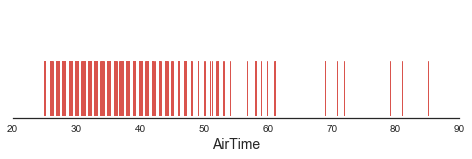

In [297]:
rug_jittered = plot_rugplot(df=local, jitter=0.1, seed=0)

In [298]:
assert_equal(len(rug_jittered.lines), len(local))

np.random.seed(0)
for i in range(len(local)):
    xdata, ydata = rug_jittered.lines[i].get_xydata().T
    assert_equal(xdata[0], xdata[1])
    assert_almost_equal(xdata[0], local.iloc[i, 0] + np.random.normal(0, 0.1)) # jitter is 0.1
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_jittered.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

In [321]:
def plot_histogram(df, bins, column='AirTime', normed=False):
    '''
    Plots a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    normed: If true, the integral of the histogram will sum to 1
            (i.e. normalized) to form a probability density.
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(df[column], bins=bins, color=sns.xkcd_rgb["denim blue"],alpha=0.5,edgecolor='black', normed=normed)
    ax.set_title('Histogram with {} bins'.format(bins),fontsize=14)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_xlim(20,90)
    sns.despine()
    return ax

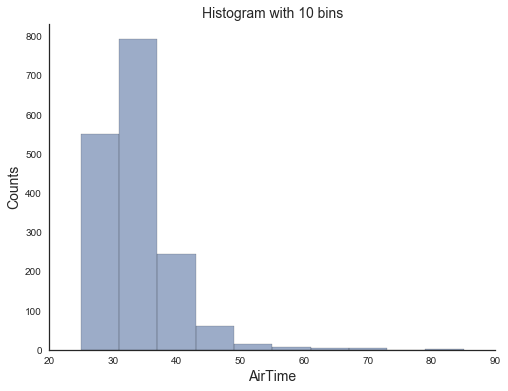

In [322]:
hist_10_bins = plot_histogram(df=local, bins=10)

In [323]:
assert_is_instance(hist_10_bins, mpl.axes.Axes)
patches = hist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
counts_a = [550, 792, 245,  61,  15,   7,   4,   4,   0,   3]
                    
for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_equal(patches[i].get_height(), counts_a[i])

# check label texts
assert_is_not(len(hist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(hist_10_bins.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(hist_10_bins.yaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

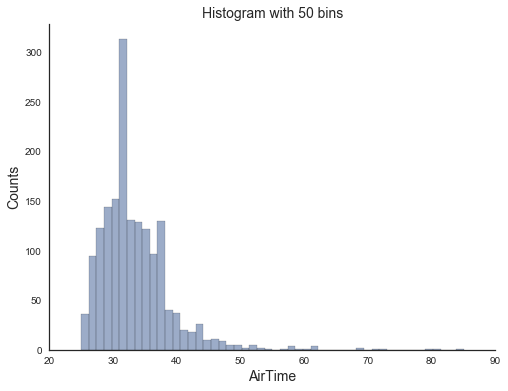

In [324]:
hist_50_bins = plot_histogram(df=local, bins=50)

In [325]:
assert_is_instance(hist_50_bins, mpl.axes.Axes)
patches = hist_50_bins.patches
assert_equal(len(patches), 50)

In [337]:
def plot_distplot(df, bins, column='AirTime'):
    '''
    Plots a "distplot".
    
    Parameters
    ----------
    df: A pandas.DataFrame
    bins: The number of bins
    column: The column to use in "df"
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    ax = sns.distplot(df[column], kde=True, rug=True, bins=bins,hist_kws={"edgecolor": "black"})
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Distplot with {} bins'.format(bins),fontsize=14)
    sns.despine()
    return ax

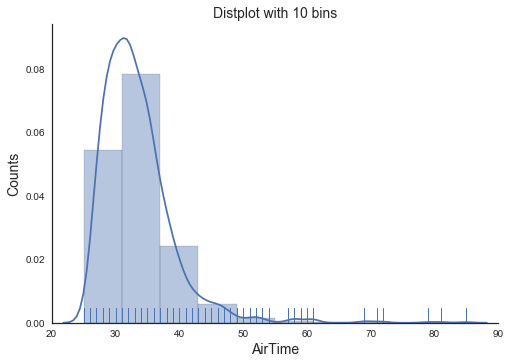

In [338]:
dist_10_bins = plot_distplot(df=local, bins=10)

In [339]:
assert_is_instance(dist_10_bins, mpl.axes.Axes)

# test histogram
patches = dist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde + rug plots
lines = dist_10_bins.lines
assert_equal(len(dist_10_bins.lines), len(local) + 1) # 1 kde + rug plots

# test kde
kdex, kdey = dist_10_bins.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# test rug plots
for i in range(len(local)):
    rugx, rugy = dist_10_bins.lines[i + 1].get_xydata().T
    assert_array_equal(rugx, local.iloc[i, 0])
    assert_equal(rugy[1] - rugy[0] > 0, True)
    
# check label texts
assert_is_not(len(dist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(dist_10_bins.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

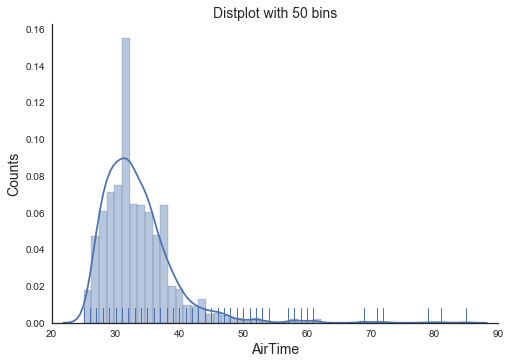

In [340]:
dist_50_bins = plot_distplot(df=local, bins=50)

In [341]:
assert_is_instance(dist_50_bins, mpl.axes.Axes)
patches = dist_50_bins.patches
assert_equal(len(patches), 50)

In [13]:
def get_silverman_bandwidth(df, column='AirTime'):
    '''
    Calculates bandwidth for KDE using Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    
    Returns
    -------
    A float
    '''
    n=len(df[column])
    std=np.std(np.array(df[column]))
    bw=1.06 * std * n ** (-1 / 5)
    return bw

In [14]:
rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(100)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.425, 3)

rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(200)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.375, 3)

In [16]:
def get_kernels(df, support, column='AirTime'):
    '''
    Generates Gaussian kernels.
    
    Parameters
    ----------
    df: A pandas.DataFrame.
    support: Input data points for the probability density function.
    column: The column that will be used in "df"
    
    Returns
    -------
    A 2-d numpy array
    '''
    bw=get_silverman_bandwidth(df, column='AirTime')
    kernels = []
    for d in df[column]:
        kernel = stats.norm(d, bw).pdf(support)
        kernels.append(kernel)
    return kernels

In [19]:
support_t = np.linspace(0, 1, 5)
rs = np.random.RandomState(0)
df_t = pd.DataFrame({'AirTime': rs.rand(2)})
kernels_t = get_kernels(df=df_t, support=support_t)
kernels_a = np.array(
    [[4.13769545e-11, 2.66353480e-03, 4.24566728e+00, 1.67579644e-01, 1.63788836e-07],
     [7.36686859e-19, 5.51357055e-08, 1.02181124e-01, 4.68917176e+00, 5.32855352e-03]]
    )
assert_array_almost_equal(kernels_t, kernels_a)

In [20]:
def normalize_kernels(support, kernels):
    '''
    Sums up the individual kernels and normalizes by total area.

    Parameters
    ----------
    support: A 1-d numpy array.
             Input data points for the probability density function.
    kernels: A 2-d numpy array.
             Kernels generated from "get_kernels()"
             
    Returns
    -------
    A 1-d numpy array
    '''
    density = np.sum(kernels, axis=0)
    density /= integrate.trapz(density, support)
    return density

In [21]:
density_t = normalize_kernels(support=support_t, kernels=kernels_t)
density_a = np.array(
    [1.797059e-11, 1.156834e-03, 1.888331e+00, 2.109355e+00, 2.314336e-03]
    )
assert_array_almost_equal(density_t, density_a)

In [60]:
def plot_scipy_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE (using scipy functions) over a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    A matplotlib.axes.Axes instance.
    '''
    kernels=get_kernels(df, support, column)
    density=normalize_kernels(support, kernels)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(support, density, color=sns.xkcd_rgb["denim blue"], linewidth=2)
    ax.hist(df[column], bins, alpha=0.6, edgecolor='black', normed=True)
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Kernel Density Plot(scipy)',fontsize=14)
    sns.despine()
    return ax

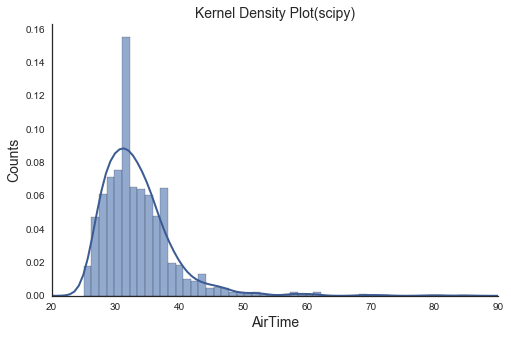

In [61]:
support = np.linspace(20, 90, 100)
kde_scipy = plot_scipy_kde(df=local, support=support)

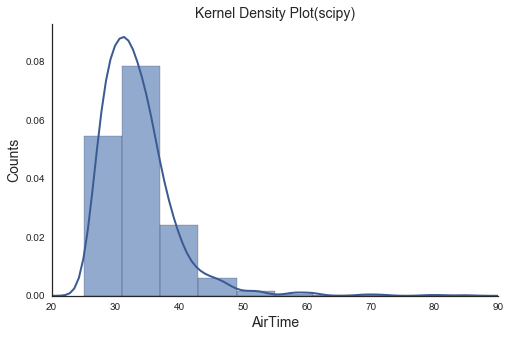

In [62]:
kde_scipy_t = plot_scipy_kde(df=local, support=support, bins=10)
assert_is_instance(kde_scipy_t, mpl.axes.Axes)

# test histogram
patches = kde_scipy_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = kde_scipy_t.lines
assert_equal(len(kde_scipy_t.lines), 1)
kdex, kdey = kde_scipy_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(kde_scipy_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(kde_scipy_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

In [65]:
def plot_sklearn_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE and a histogram using sklearn.KernelDensity.
    Uses Gaussian kernels.
    The optimal bandwidth is calculated according to Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    ax: A matplotlib.axes.Axes instance.
    kde: A sklearn.neighbors.kde.KernelDensity instance.
    '''
    bw=get_silverman_bandwidth(df, column='AirTime')
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    x=df[column]
    kde.fit(x[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(x, bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], edgecolor='black',normed=True)
    ax.plot(support, np.exp(y))
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Kernel Density Plot(sklearn)',fontsize=14)
    sns.despine()
    return ax, kde

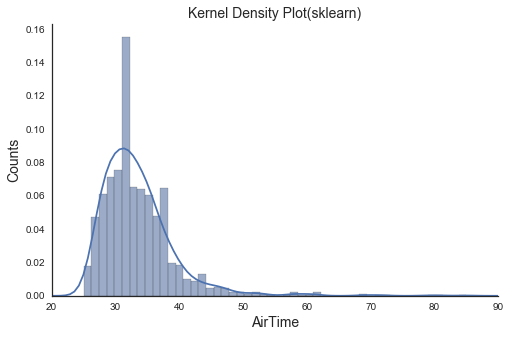

In [66]:
ax_kde_sklearn, kde_sklearn = plot_sklearn_kde(df=local, support=support)

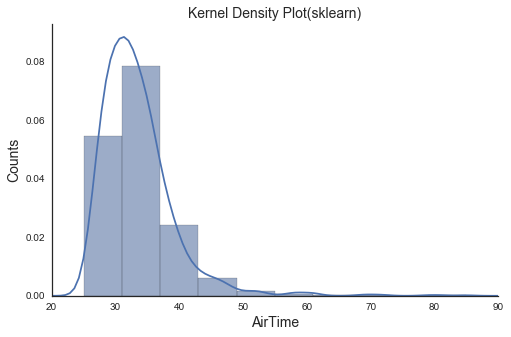

In [67]:
ax_kde_sklearn_t, kde_sklearn_t = plot_sklearn_kde(df=local, support=support, bins=10)
assert_is_instance(ax_kde_sklearn_t, mpl.axes.Axes)
assert_is_instance(kde_sklearn_t, KernelDensity)

# test histogram
patches = ax_kde_sklearn_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = ax_kde_sklearn_t.lines
assert_equal(len(ax_kde_sklearn_t.lines), 1)
kdex, kdey = ax_kde_sklearn_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(ax_kde_sklearn_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(ax_kde_sklearn_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")